In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
import math


### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

-0.01084098704 0.02815552265 0.00039265133851975654
-0.01084098704 0.02815552265 0.00039265133851975654


Text(0.5, 1.0, 'Original matrix')

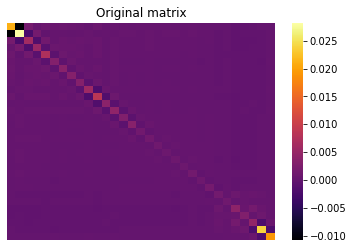

In [2]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)

# scaler_sys = StandardScaler()
# scaler_sys.fit(syscov)
# syscov_sc = scaler_sys.transform(syscov)

print(np.min(syscov), np.max(syscov), np.mean(syscov))
sns.heatmap(pd.DataFrame(syscov), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix')

In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)


In [4]:
# syscov_triang = np.triu(syscov)

        

# sns.heatmap(scaler_sys.inverse_transform(syscov_triang), 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True,
#         robust=False)

In [5]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        p = symmetrical(p)
        matrixset[it, :, :] = p
    return matrixset


In [6]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
    #         if np.iscomplex(syscov[i,j]):
    #             print("COMPLEX")
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) < np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix

In [7]:

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

### Generate a data set with covariance matrix from the original plus gaussian noise

In [8]:
magnitudes = matrixMag(syscov_sc)

In [9]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))
permMatrix = permutMatrix(syscov_sc, numMatrix)
print(np.shape(permMatrix))

(10000, 31, 31)


Text(0.5, 1.0, 'PERMUTATED MATRIX')

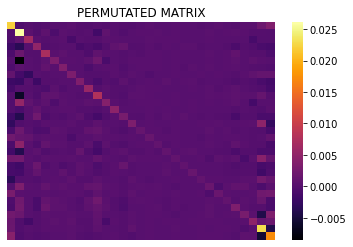

In [10]:
# sns.heatmap(pd.DataFrame(permMatrix[99, :, : ]), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX")

In [11]:
# syscov_sc

In [12]:


for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.rand()
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-4*err*10**magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col] + 1e-4*10**err*magnitudes[row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] 
                covset_noise[i, row, col] = permMatrix[i, row, col]  + 0.001*err*10**magnitudes[row, col]
#                 filled_matrix[row, col] = 0.1*np.random.rand()*10**magnitudes[row, col]


            
#     covset[i,:,:] = scalercov.transform(covset[i,:,:])
#     covset_noise[i,:,:] = scalercov.transform(covset_noise[i,:,:])
            

# covset = scalercov.transform(covset)
# covset_noise = scalercov.transform(covset_noise)

 Generating 10000 matrix                     

In [13]:
# sns.heatmap(pd.DataFrame(covset_log[100]), 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True)

In [14]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

(10000, 31, 31)


Text(0.5, 1.0, 'NOISE MATRIX')

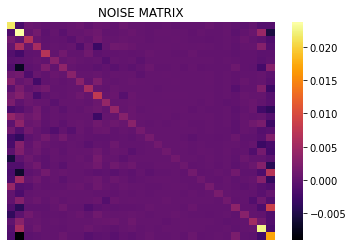

In [15]:
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(covset_noise_test[0])), 
# sns.heatmap(pd.DataFrame(covset_noise_test[100]), 
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("NOISE MATRIX")

Text(0.5, 1.0, 'TEST MATRIX')

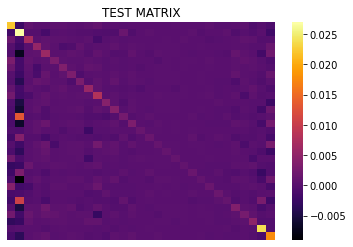

In [16]:
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(covset_test[10])), 
# sns.heatmap(pd.DataFrame(np.exp(covset_test[100])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")
# np.exp(covset_test[0])

In [17]:
input_img = tf.keras.Input(shape=(31, 31, 1))

x = layers.ZeroPadding2D(((5,4),(5,4)))(input_img)
x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
decoded = layers.Cropping2D(cropping=((5, 4), (5, 4)))(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 31, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 8)         1160  

In [18]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                        min_delta=0,
#                                        patience=,
#                                        verbose=1, 
#                                        mode='auto')]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=300,
                batch_size=32,
#                 callbacks=callbacks, 
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))

Epoch 1/100
500/500 [==============================] - 43s 85ms/step - loss: 0.5358 - val_loss: 0.3607
Epoch 2/100
500/500 [==============================] - 42s 85ms/step - loss: 0.3374 - val_loss: 0.3248
Epoch 3/100
500/500 [==============================] - 42s 84ms/step - loss: 0.3260 - val_loss: 0.3248
Epoch 4/100
500/500 [==============================] - 44s 87ms/step - loss: 0.3226 - val_loss: 0.3165
Epoch 5/100
500/500 [==============================] - 43s 86ms/step - loss: 0.3195 - val_loss: 0.3196
Epoch 6/100
500/500 [==============================] - 42s 85ms/step - loss: 0.3141 - val_loss: 0.3138
Epoch 7/100
500/500 [==============================] - 44s 87ms/step - loss: 0.3112 - val_loss: 0.3042
Epoch 8/100
500/500 [==============================] - 40s 79ms/step - loss: 0.3074 - val_loss: 0.3053
Epoch 9/100
500/500 [==============================] - 41s 82ms/step - loss: 0.3069 - val_loss: 0.3032
Epoch 10/100
500/500 [==============================] - 42s 85ms/step - l

500/500 [==============================] - 40s 80ms/step - loss: 0.2736 - val_loss: 0.2736
Epoch 80/100
500/500 [==============================] - 40s 80ms/step - loss: 0.2731 - val_loss: 0.2744
Epoch 81/100
500/500 [==============================] - 40s 79ms/step - loss: 0.2734 - val_loss: 0.2753
Epoch 82/100
500/500 [==============================] - 40s 79ms/step - loss: 0.2732 - val_loss: 0.2741
Epoch 83/100
500/500 [==============================] - 40s 80ms/step - loss: 0.2732 - val_loss: 0.2741
Epoch 84/100
500/500 [==============================] - 40s 79ms/step - loss: 0.2733 - val_loss: 0.2729
Epoch 85/100
500/500 [==============================] - 40s 80ms/step - loss: 0.2728 - val_loss: 0.2766
Epoch 86/100
500/500 [==============================] - 40s 80ms/step - loss: 0.2727 - val_loss: 0.2737
Epoch 87/100
500/500 [==============================] - 40s 80ms/step - loss: 0.2728 - val_loss: 0.2731
Epoch 88/100
500/500 [==============================] - 40s 79ms/step - loss:

(array([0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

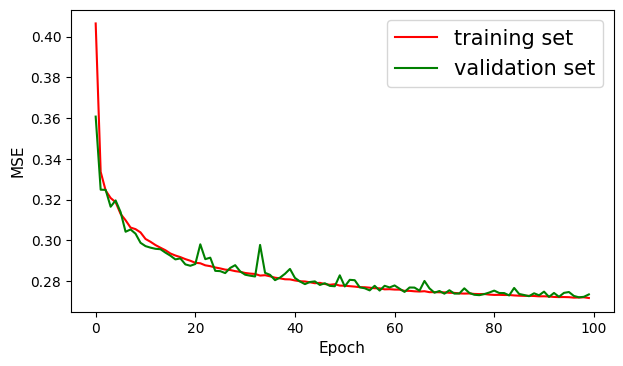

In [19]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [20]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

0.27199986577033997 0.2716689705848694


In [21]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

In [22]:
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True,
#         robust=False)
# plt.title('Test noise matrix')
np.shape(np.mean(covset_noise_test, axis=0)), np.shape(covset_noise_test[0])

((31, 31), (31, 31))

(2000, 31, 31)
(1, 31, 31, 1)
(31, 31)


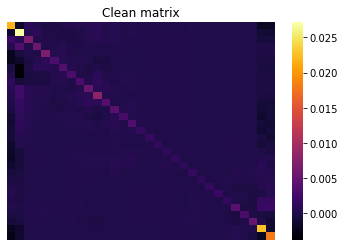

In [23]:
print(np.shape(covset_noise_test))
clean_img = autoencoder.predict(covset_noise_test[0,:,:].reshape(1,31,31))

print(np.shape(clean_img))
# clean_imgr = np.exp(clean_img.reshape(31,31))
clean_imgr = scalercov.inverse_transform(clean_img.reshape(31,31))
# clean_imgr = symmetrical(clean_imgr)
print(np.shape(clean_imgr))

# clean_imgr = symmetrical(clean_imgr)
sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Clean matrix')

np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")
# scaler_sys.inverse_transform(clean_img.reshape(31,31))

Text(0.5, 1.0, 'Filled matrix')

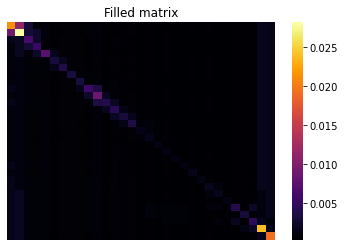

In [24]:
filled_matrix = np.zeros((nsize, nsize))
err = np.random.rand()
for row in range(nsize):
    for col in range(nsize):
        if row == col:
#             err = np.random.randn()
            filled_matrix[row, col] = syscov_sc[row, col] 
#     + 0.1*err*magnitudes[row, col]
        else:
            filled_matrix[row, col] = 10*err*10**magnitudes[row, col] # this work with original syscov
#             filled_matrix[row, col] = 0.001*np.random.rand()

filled_matrix = scalercov.inverse_transform(filled_matrix)
# filled_matrix = symmetrical(filled_matrix)

sns.heatmap(pd.DataFrame(filled_matrix), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Filled matrix')


Text(0.5, 1.0, 'Reconstructed matrix with conv-AE')

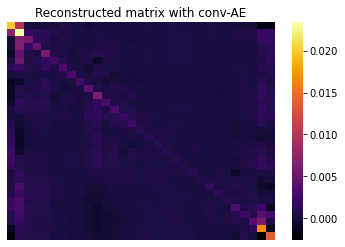

In [25]:
filled_matrix = scalercov.transform(filled_matrix).reshape(1,31,31,1)
# filled_matrix = filled_matrix.reshape(1,31,31,1)

clean_img = autoencoder.predict(filled_matrix)

clean_imgr = scalercov.inverse_transform(clean_img[0,:,:,0].reshape(31,31))
# clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Reconstructed matrix with conv-AE')
# plt.savefig('rec_matrix_conv_ae.png')

In [26]:
err

0.19309424106914563

In [27]:
# clean_imgr = symmetrical(clean_imgr)

In [28]:
np.savetxt("fake_binned_JLA_COVdecodedTEST2.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

In [29]:
autoencoder.save('../models/autoencoderCONV_JLA.h5')
# decoder.save('../models/decoderJLA.h5')
# encoder.save('../models/encoderJLA.h5')

In [30]:
# sns.heatmap(pd.DataFrame(clean_imgr), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', 
#             robust=False)